In [21]:
import pandas as pd
import numpy as np
import string
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import re
import multiprocessing
#import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
nltk.download("stopwords")

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acrai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
col_names = ["date","season","neutral","playoff","team1","team2","elo1_pre","elo2_pre","elo_prob1","elo_prob2","elo1_post","elo2_post","qbelo1_pre","qbelo2_pre","qb1","qb2","qb1_value_pre","qb2_value_pre","qb1_adj","qb2_adj","qbelo_prob1","qbelo_prob2","qb1_game_value","qb2_game_value","qb1_value_post","qb2_value_post","qbelo1_post","qbelo2_post","score1","score2","quality","importance","total_rating"]

df = pd.read_csv("https://projects.fivethirtyeight.com/nfl-api/nfl_elo.csv", names=col_names)

#Drop the first row
df = df.iloc[1:]
df = df.reset_index(drop=True)


In [23]:
#Display the first 5 rows of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            17379 non-null  object
 1   season          17379 non-null  object
 2   neutral         17379 non-null  object
 3   playoff         616 non-null    object
 4   team1           17379 non-null  object
 5   team2           17379 non-null  object
 6   elo1_pre        17379 non-null  object
 7   elo2_pre        17379 non-null  object
 8   elo_prob1       17379 non-null  object
 9   elo_prob2       17379 non-null  object
 10  elo1_post       17379 non-null  object
 11  elo2_post       17379 non-null  object
 12  qbelo1_pre      15217 non-null  object
 13  qbelo2_pre      15217 non-null  object
 14  qb1             15217 non-null  object
 15  qb2             15217 non-null  object
 16  qb1_value_pre   15217 non-null  object
 17  qb2_value_pre   15217 non-null  object
 18  qb1_ad

In [24]:
#Display the first 5 rows of the dataframe
df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
0,1920-09-26,1920,0,NaN,RII,STP,1503.947,1300.0,0.8246512009492516,0.1753487990507484,...,NaN,NaN,NaN,NaN,NaN,48,0,NaN,NaN,NaN
1,1920-10-03,1920,0,NaN,AKR,WHE,1503.42,1300.0,0.8242120973373386,0.17578790266266142,...,NaN,NaN,NaN,NaN,NaN,43,0,NaN,NaN,NaN
2,1920-10-03,1920,0,NaN,BFF,WBU,1478.004,1300.0,0.8020003005487033,0.1979996994512967,...,NaN,NaN,NaN,NaN,NaN,32,6,NaN,NaN,NaN
3,1920-10-03,1920,0,NaN,DAY,COL,1493.002,1504.908,0.5758191240920725,0.4241808759079275,...,NaN,NaN,NaN,NaN,NaN,14,0,NaN,NaN,NaN
4,1920-10-03,1920,0,NaN,RII,MUN,1516.108,1478.004,0.6441710901126361,0.35582890988736393,...,NaN,NaN,NaN,NaN,NaN,45,0,NaN,NaN,NaN


In [25]:
#QB ELO Preprocessing


#Copy the original dataframe to a new dataframe
qbelo_df = df.copy()

#Drop rows with NaN values in qbelo1_pre and qbelo2_pre
qbelo_df = qbelo_df .dropna(subset=["qbelo1_pre", "qbelo2_pre"])

#Convert the date column to datetime
qbelo_df ["date"] = pd.to_datetime(qbelo_df ["date"])

#Convert Score1 and Score2 to int
qbelo_df ["score1"] = qbelo_df ["score1"].astype(int)
qbelo_df ["score2"] = qbelo_df ["score2"].astype(int)

#Convert NaN values in qbelo1_pre and qbelo2_pre to 0
qbelo_df ["qbelo1_pre"] = qbelo_df ["qbelo1_pre"].fillna(0)
qbelo_df ["qbelo2_pre"] = qbelo_df ["qbelo2_pre"].fillna(0)

#Convert qbelo1_pre and qbelo2_pre to float
qbelo_df ["qbelo1_pre"] = qbelo_df ["qbelo1_pre"].astype(float)
qbelo_df ["qbelo2_pre"] = qbelo_df ["qbelo2_pre"].astype(float)



#Drop all columns except date, qbelo1_pre, qbelo2_pre, score1, score2
qbelo_df = qbelo_df [["date", "qbelo1_pre", "qbelo2_pre", "score1", "score2"]]

#print(qbelo_df .head())

#Add a new column "winner" to the dataframe and set the value to 1 if score1 > score2, else 2
qbelo_df ["winner"] = np.where(qbelo_df ["score1"] > qbelo_df ["score2"], 1, 2)

#Drop the columns score1 and score2
qbelo_df = qbelo_df .drop(["score1", "score2"], axis=1)

#Add a column qbelo_diff to the dataframe and set the value to qbelo1_pre - qbelo2_pre
qbelo_df ["qbelo_diff"] = qbelo_df ["qbelo1_pre"] - qbelo_df ["qbelo2_pre"]

#Drop the columns qbelo1_pre and qbelo2_pre
qbelo_df = qbelo_df .drop(["qbelo1_pre", "qbelo2_pre"], axis=1)

#Set the date column as the index of the dataframe
qbelo_df .set_index("date", inplace=True)


#Display the first 5 rows of the dataframe
qbelo_df .info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15217 entries, 1950-09-16 to 2023-02-12
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   winner      15217 non-null  int32  
 1   qbelo_diff  15217 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 297.2 KB


In [26]:
#Display the first 5 rows of the dataframe
qbelo_df.head()


,winner,qbelo_diff
date,,
1950-09-16,2,28.902443
1950-09-17,2,-117.089957
1950-09-17,2,23.296071
1950-09-17,2,-95.303577
1950-09-17,2,-63.142167


In [27]:
#Create a model to predict the winner of a game based qbelo_diff

#Split the data into features and target variable
X = qbelo_df[["qbelo_diff"]]
y = qbelo_df["winner"]

#Create a loop to test the accuracy of the model with different values of n
for i in range(1, 11):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=i)
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Random state: {i} - Accuracy: {accuracy}")
    


Random state: 1 - Accuracy: 0.657030223390276
Random state: 2 - Accuracy: 0.6562417871222076
Random state: 3 - Accuracy: 0.6436268068331144
Random state: 4 - Accuracy: 0.6375821287779238
Random state: 5 - Accuracy: 0.6604467805519054
Random state: 6 - Accuracy: 0.6488830486202365
Random state: 7 - Accuracy: 0.652562417871222
Random state: 8 - Accuracy: 0.6515111695137976
Random state: 9 - Accuracy: 0.6607095926412615
Random state: 10 - Accuracy: 0.6467805519053876


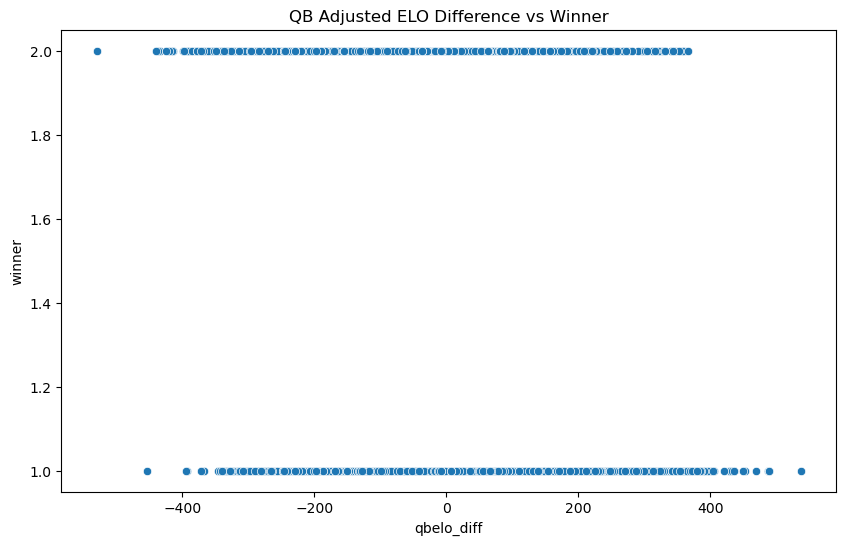

In [28]:
#Plot the qb elo difference vs the winner
plt.figure(figsize=(10, 6))
sns.scatterplot(x="qbelo_diff", y="winner", data=qbelo_df)
plt.title("QB Adjusted ELO Difference vs Winner")

#Save the chart
plt.savefig("Images\qb_elo_diff_vs_winner.png")

#Display the chart
plt.show()


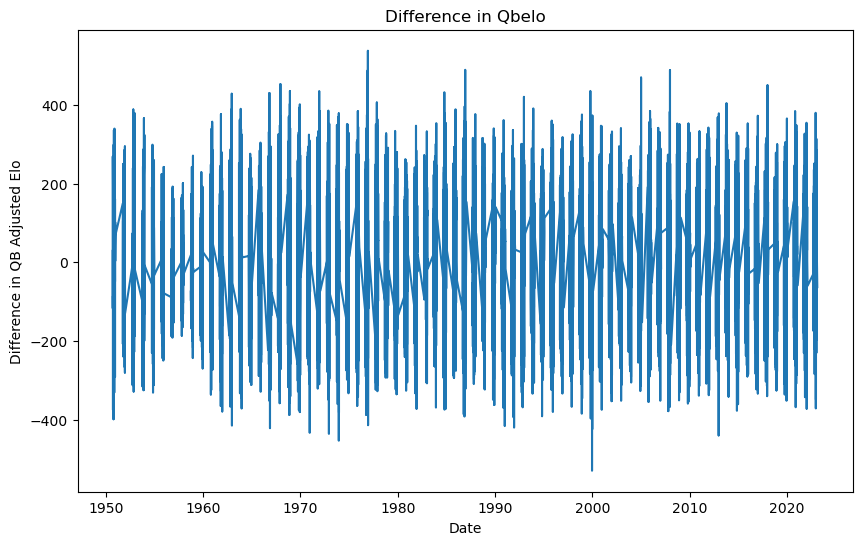

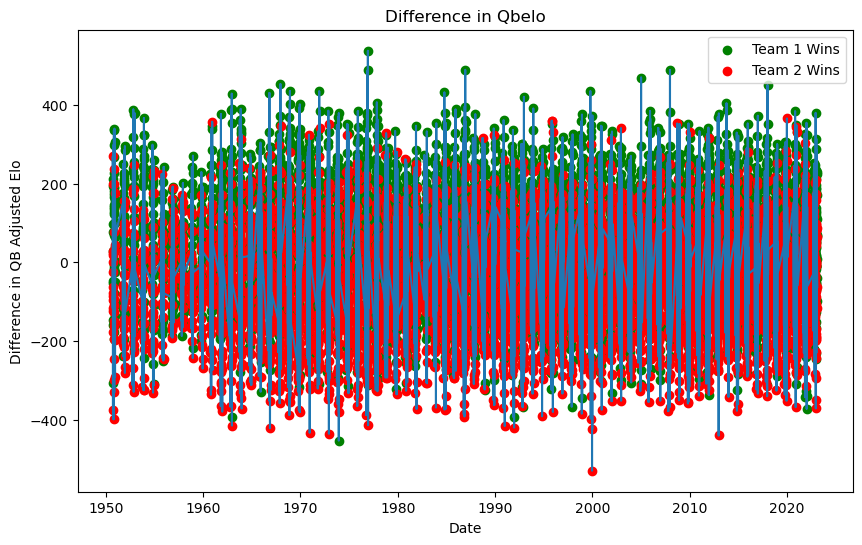

In [29]:
#Chart the data to show the qbelo_diff
plt.figure(figsize=(10,6))
plt.title("Difference in Qbelo")
plt.xlabel("Date")
plt.ylabel("Difference in QB Adjusted Elo")
plt.plot(qbelo_df ["qbelo_diff"])

#Save the chart
plt.savefig("Images\qb_elo_diff.png")

#Display the chart
plt.show()

#Add the winner to the chart
plt.figure(figsize=(10,6))
plt.title("Difference in Qbelo")
plt.xlabel("Date")
plt.ylabel("Difference in QB Adjusted Elo")
plt.plot(qbelo_df ["qbelo_diff"])
plt.scatter(qbelo_df [qbelo_df ["winner"] == 1].index, qbelo_df [qbelo_df ["winner"] == 1]["qbelo_diff"], label="Team 1 Wins", color="g")
plt.scatter(qbelo_df [qbelo_df ["winner"] == 2].index, qbelo_df [qbelo_df ["winner"] == 2]["qbelo_diff"], label="Team 2 Wins", color="r")
plt.legend()

#Save the chart
plt.savefig("Images\qb_elo_diff_with_winner.png")

#Display the chart
plt.show()





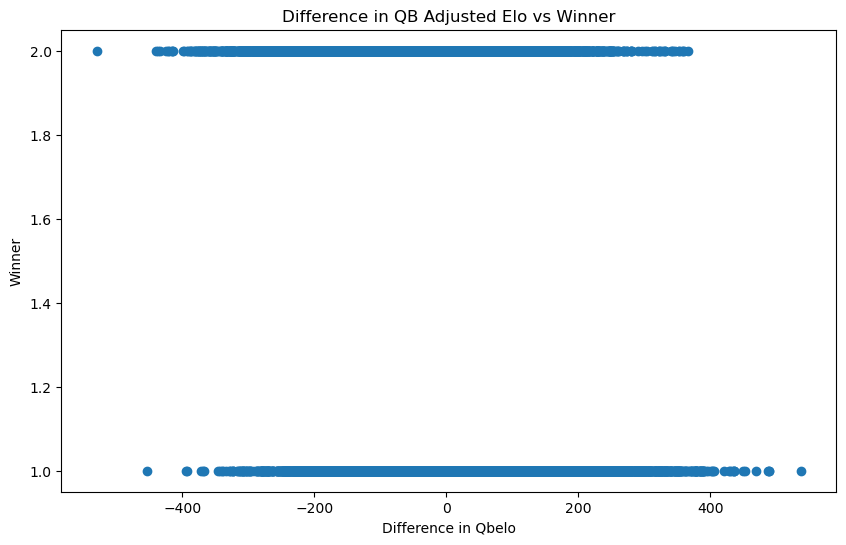

In [30]:
#Compare the qbelo_diff vs the winner
plt.figure(figsize=(10,6))
plt.title("Difference in QB Adjusted Elo vs Winner")
plt.xlabel("Difference in Qbelo")
plt.ylabel("Winner")
plt.scatter(qbelo_df ["qbelo_diff"], qbelo_df ["winner"])
plt.show()


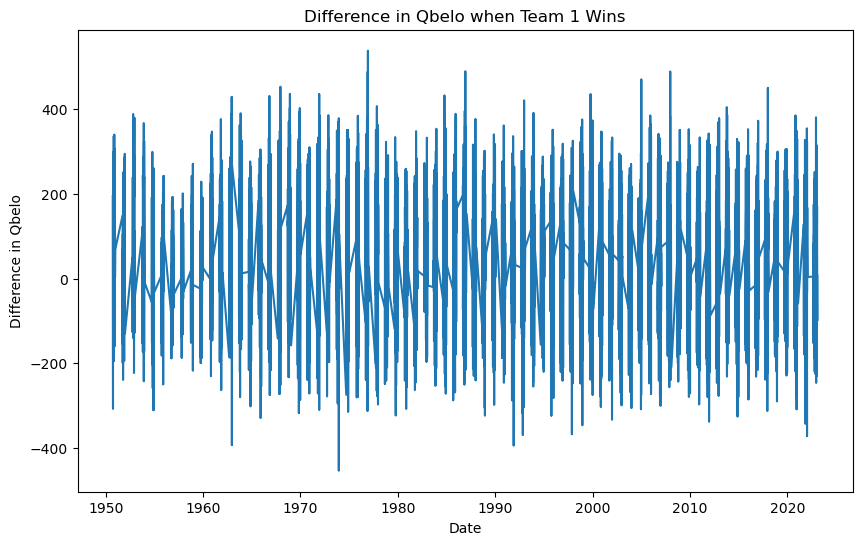

In [39]:
#Chart the data to show the qbelo_diff when team 1 wins
plt.figure(figsize=(10,6))
plt.title("Difference in Qbelo when Team 1 Wins")
plt.xlabel("Date")
plt.ylabel("Difference in Qbelo")
plt.plot(qbelo_df [qbelo_df ["winner"] == 1]["qbelo_diff"])

#Save the chart
plt.savefig("Images\qb_elo_diff_team1_wins.png")

#Display the chart
plt.show()


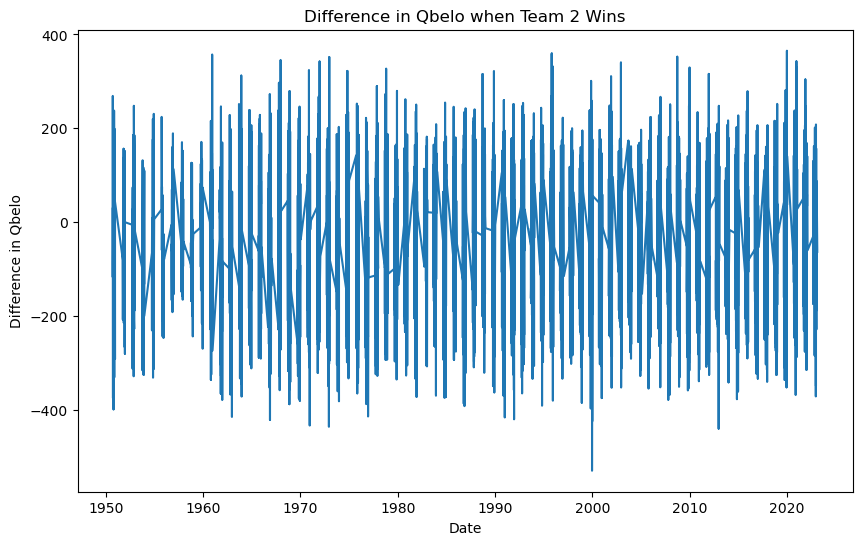

In [41]:
#Chart the data to show the qbelo_diff when team 2 wins
plt.figure(figsize=(10,6))
plt.title("Difference in Qbelo when Team 2 Wins")
plt.xlabel("Date")
plt.ylabel("Difference in Qbelo")
plt.plot(qbelo_df [qbelo_df ["winner"] == 2]["qbelo_diff"])

#Save the chart
plt.savefig("Images\qb_elo_diff_team2_wins.png")

#Display the chart
plt.show()


In [33]:
#Total ELO Preprocessing

#Create a copy of the dataframe
total_elo_df = df.copy()



#Drop the rows with elo1_pre and elo2_pre are NaN
total_elo_df = total_elo_df.dropna(subset=["elo1_pre", "elo2_pre","qbelo1_pre","qbelo2_pre"])

#Convert the date column to datetime
total_elo_df["date"] = pd.to_datetime(total_elo_df["date"])

#Convert the score1 and score2 columns to int
total_elo_df["score1"] = total_elo_df["score1"].astype(int)
total_elo_df["score2"] = total_elo_df["score2"].astype(int)

#Convert the elo1_pre and elo2_pre columns to float
total_elo_df["elo1_pre"] = total_elo_df["elo1_pre"].astype(float)
total_elo_df["elo2_pre"] = total_elo_df["elo2_pre"].astype(float)

#Convert the qbelo1_pre and qbelo2_pre columns to float
total_elo_df["qbelo1_pre"] = total_elo_df["qbelo1_pre"].astype(float)
total_elo_df["qbelo2_pre"] = total_elo_df["qbelo2_pre"].astype(float)

#Create a new column ((elo1_pre + qbelo1_pre) - (elo2_pre + qbelo2_pre)) and add it to the dataframe
total_elo_df["elo_total_diff"] = (total_elo_df["elo1_pre"] + total_elo_df["qbelo1_pre"]) - (total_elo_df["elo2_pre"] + total_elo_df["qbelo2_pre"])

#Drop the elo1_pre, elo2_pre, qbelo1_pre, qbelo2_pre columns
total_elo_df = total_elo_df.drop(["elo1_pre", "elo2_pre", "qbelo1_pre", "qbelo2_pre"], axis=1)

#Set the date column as the index of the dataframe
total_elo_df.set_index("date", inplace=True)

#Create a new column "winner" and set the value to 1 if score1 > score2, else 2
total_elo_df["winner"] = np.where(total_elo_df["score1"] > total_elo_df["score2"], 1, 2)

#Drop columns score1, score2, elo1_post, elo2_post, qbelo1_post, qbelo2_post, qb1, qb2, qb1_value_pre, qb2_value_pre, qb1_adj, qb2_adj, qbelo_prob1, qbelo_prob2, qb1_game_value, qb2_game_value, qb1_value_post, qb2_value_post, qbelo1_post, qbelo2_post, quality, importance, total_rating, team1, team2, season, neutral, playoff
total_elo_df = total_elo_df.drop(["score1", "score2", "elo1_post", "elo2_post", "qbelo1_post", "qbelo2_post", "qb1", "qb2", "qb1_value_pre", "qb2_value_pre", "qb1_adj", "qb2_adj", "qbelo_prob1", "qbelo_prob2", "qb1_game_value", "qb2_game_value", "qb1_value_post", "qb2_value_post", "qbelo1_post", "qbelo2_post", "quality", "importance", "total_rating", "team1", "team2", "season", "neutral", "playoff"], axis=1)

total_elo_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15217 entries, 1950-09-16 to 2023-02-12
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   elo_prob1       15217 non-null  object 
 1   elo_prob2       15217 non-null  object 
 2   elo_total_diff  15217 non-null  float64
 3   winner          15217 non-null  int32  
dtypes: float64(1), int32(1), object(2)
memory usage: 535.0+ KB


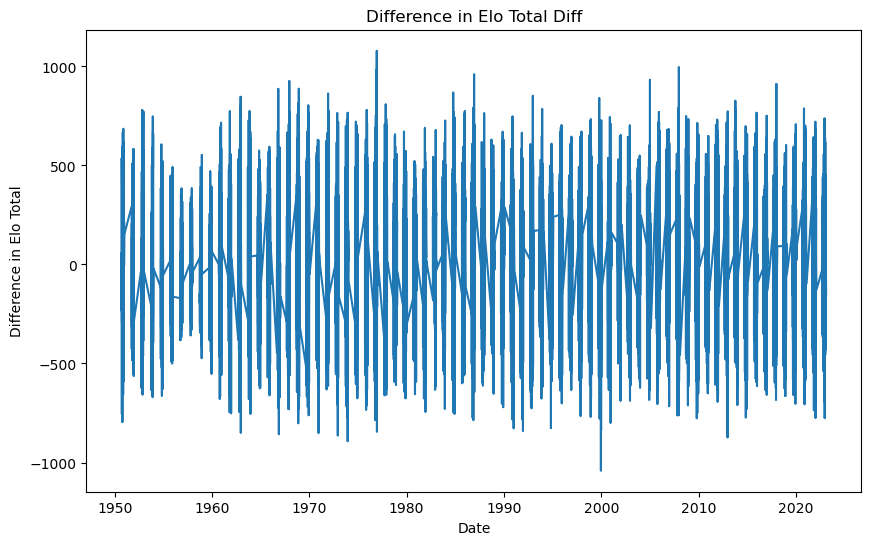

In [34]:
#Chart the data to show the elo_total
plt.figure(figsize=(10,6))
plt.title("Difference in Elo Total Diff")
plt.xlabel("Date")
plt.ylabel("Difference in Elo Total")
plt.plot(total_elo_df["elo_total_diff"])
plt.show()


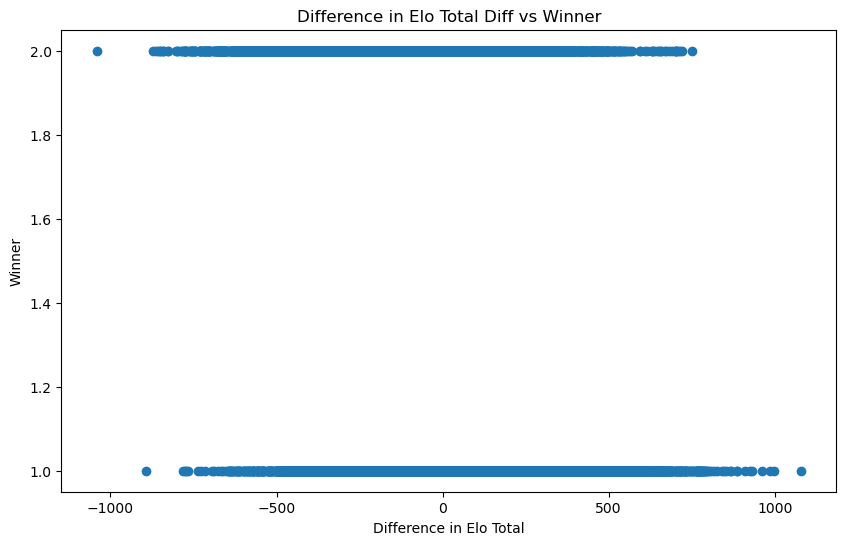

In [35]:
#Cgart the data to show difference in who wins by elo_total
plt.figure(figsize=(10,6))
plt.title("Difference in Elo Total Diff vs Winner")
plt.xlabel("Difference in Elo Total")
plt.ylabel("Winner")
plt.scatter(total_elo_df["elo_total_diff"], total_elo_df["winner"])
plt.show()



In [36]:
#Show the top 5 rows of the dataframe
total_elo_df.head()

,elo_prob1,elo_prob2,elo_total_diff,winner
date,,,,
1950-09-16,0.6294019745620898,0.3705980254379102,55.912443,2
1950-09-17,0.42585068548043653,0.5741493145195635,-233.996957,2
1950-09-17,0.6255294000642098,0.37447059993579024,47.428071,2
1950-09-17,0.45624508306368117,0.5437549169363188,-190.785577,2
1950-09-17,0.5013211051227595,0.4986788948772405,-127.224167,2


In [37]:
#Team ELO Preprocessing

#Create a copy of the dataframe
team_elo_df = df.copy()



#Drop the rows with elo1_pre and elo2_pre are NaN
team_elo_df = team_elo_df.dropna(subset=["elo1_pre", "elo2_pre","qbelo1_pre","qbelo2_pre"])

#Convert the date column to datetime
team_elo_df["date"] = pd.to_datetime(team_elo_df["date"])

#Convert the score1 and score2 columns to int
team_elo_df["score1"] = team_elo_df["score1"].astype(int)
team_elo_df["score2"] = team_elo_df["score2"].astype(int)

#Convert the elo1_pre and elo2_pre columns to float
team_elo_df["elo1_pre"] = team_elo_df["elo1_pre"].astype(float)
team_elo_df["elo2_pre"] = team_elo_df["elo2_pre"].astype(float)


#Create a new column ((elo1_pre + qbelo1_pre) - (elo2_pre + qbelo2_pre)) and add it to the dataframe
team_elo_df["elo_team_diff"] = (team_elo_df["elo1_pre"] - team_elo_df["elo2_pre"])

#Drop the elo1_pre, elo2_pre, qbelo1_pre, qbelo2_pre columns
team_elo_df = team_elo_df.drop(["elo1_pre", "elo2_pre"], axis=1)

#Set the date column as the index of the dataframe
team_elo_df.set_index("date", inplace=True)

#Create a new column "winner" and set the value to 1 if score1 > score2, else 2
team_elo_df["winner"] = np.where(team_elo_df["score1"] > team_elo_df["score2"], 1, 2)

#Drop columns score1, score2, elo1_post, elo2_post, qbelo1_post, qbelo2_post, qb1, qb2, qb1_value_pre, qb2_value_pre, qb1_adj, qb2_adj, qbelo_prob1, qbelo_prob2, qb1_game_value, qb2_game_value, qb1_value_post, qb2_value_post, qbelo1_post, qbelo2_post, quality, importance, total_rating, team1, team2, season, neutral, playoff, qbelo1_pre, qbelo2_pre
team_elo_df = team_elo_df.drop(["score1", "score2", "elo1_post", "elo2_post", "qbelo1_post", "qbelo2_post", "qb1", "qb2", "qb1_value_pre", "qb2_value_pre", "qb1_adj", "qb2_adj", "qbelo_prob1", "qbelo_prob2", "qb1_game_value", "qb2_game_value", "qb1_value_post", "qb2_value_post", "qbelo1_post", "qbelo2_post", "quality", "importance", "total_rating", "team1", "team2", "season", "neutral", "playoff", "qbelo1_pre", "qbelo2_pre"], axis=1)

team_elo_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15217 entries, 1950-09-16 to 2023-02-12
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   elo_prob1      15217 non-null  object 
 1   elo_prob2      15217 non-null  object 
 2   elo_team_diff  15217 non-null  float64
 3   winner         15217 non-null  int32  
dtypes: float64(1), int32(1), object(2)
memory usage: 535.0+ KB


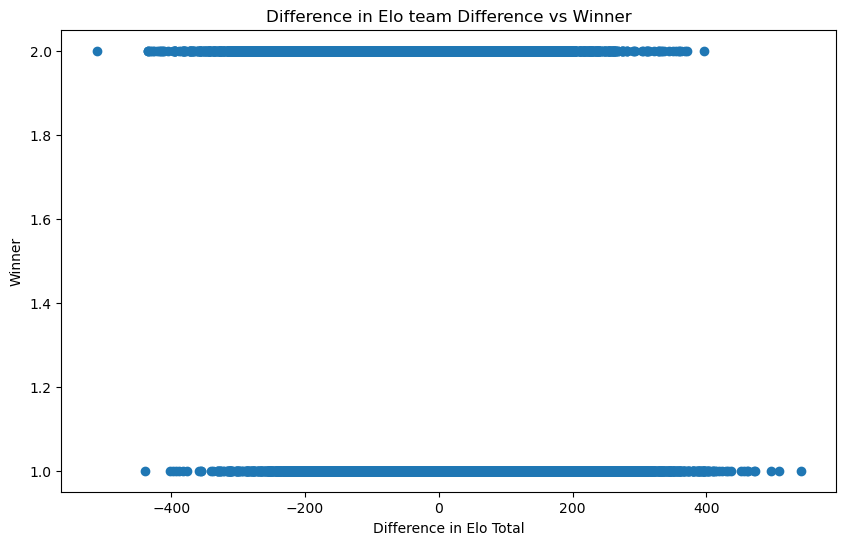

In [38]:
#Chart the data to show difference in who wins by elo_total
plt.figure(figsize=(10,6))
plt.title("Difference in Elo team Difference vs Winner")
plt.xlabel("Difference in Elo Total")
plt.ylabel("Winner")
plt.scatter(team_elo_df["elo_team_diff"], team_elo_df["winner"])
plt.show()
